In [1]:
import sys

import torch
import torchvision
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
# GET DATA
train_data = datasets.FashionMNIST(
    root="data",           # where to download data to?
    train=True,            # do we want the training dataset?
    download=True,         # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(),  # how do we want to transform the data?
    target_transform=None  # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [26]:
len(test_data)

10000

In [3]:
# GET FIRST TRAINING EXAMPLE
image, label = train_data[0]

class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [4]:
# MODEL
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinyVGG
    model from the CNN Explainer website
    """

    # Initialize the class
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
        x = self.conv_block_2(x)
        # Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
        x = self.classifier(x)
        # Output shape of classifier: torch.Size([1, 10])
        return x

In [5]:
# INSTANTIATE MODEL
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

# Skip to "load from disk"

In [23]:
# LOSS FUNCTION & OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [7]:
# TRAINING
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    # Performs a training with model trying to learn on data_loader.
    train_loss, train_acc = 0, 0

    # Put model into training mode
    model.train()

    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass (outputs the raw logits from the model)
        y_pred = model(X)

        # 2. Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss  # accumulate train loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))  # go from logits -> prediction labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step (update the model's parameters once *per batch*)
        optimizer.step()

    # Divide total train loss and acc by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"\nTrain loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")


In [8]:
# TESTING
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    # Performs a testing loop step on model going over data_loader.
    test_loss, test_acc = 0, 0

    # Put the model in eval mode
    model.eval()

    # Turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send the data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass (outputs raw logits)
            test_pred = model(X)

            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))  # go from logits -> prediction labels

        # Adjust metrics and # print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [6]:
from torch.utils.data import DataLoader

# Set up the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [7]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [24]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [12]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    # Prints difference between start and end time.
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

In [21]:
# EVALUATE MODEL
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make our data device agnostic
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,  # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [14]:
# TRAIN AND TEST MODEL
from timeit import default_timer as timer

train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"\n\nEpoch: {epoch}\n-------")

    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)

    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

print("\nModel_2 Results:", model_2_results)

  0%|          | 0/3 [00:00<?, ?it/s]



Epoch: 0
-------

Train loss: 0.60505 | Train acc: 78.05%
Test loss: 0.40506 | Test acc: 85.10%



Epoch: 1
-------

Train loss: 0.35619 | Train acc: 87.15%
Test loss: 0.35674 | Test acc: 86.80%



Epoch: 2
-------

Train loss: 0.31947 | Train acc: 88.49%
Test loss: 0.33661 | Test acc: 87.83%


Train time on cpu: 52.675 seconds


  0%|          | 0/313 [00:00<?, ?it/s]


Model_2 Results: {'model_name': 'FashionMNISTModelV2', 'model_loss': 0.33660516142845154, 'model_acc': 87.82947284345047}


# Load from disk

In [9]:
from pathlib import Path

# Instantiate a fresh instance of LinearRegressionModelV2
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

# Load model state dict
model_2.load_state_dict(torch.load("../models/03_pytorch_computer_vision_model_2.pth"))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
model_2.to(device)


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [10]:
# MAKE PREDICTIONS
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob)

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [16]:
# MAKE RANDOM DUMMY DATASET
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sneaker')

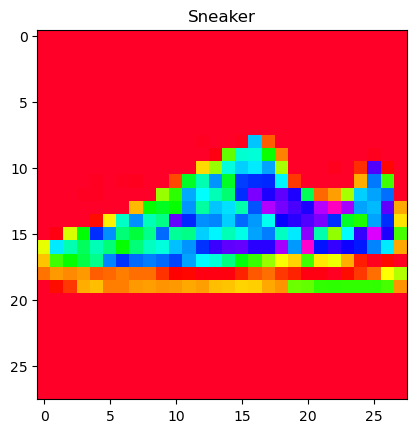

In [21]:
# SHOW 1ST SAMPLE
import matplotlib.pyplot as plt

plt.imshow(test_samples[0].squeeze(), cmap="gist_rainbow")
plt.title(class_names[test_labels[0]])

In [17]:
# MAKE PREDICTIONS
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# VIEW 1ST TWO
pred_probs[:2]

tensor([[7.9029e-08, 9.9999e-01, 9.4142e-10, 5.6140e-06, 2.8607e-09, 1.7585e-09,
         1.3671e-08, 1.2263e-08, 3.1639e-09, 1.1045e-09],
        [8.3185e-01, 1.4863e-04, 2.2749e-03, 1.6120e-02, 2.1314e-05, 1.4607e-07,
         1.4956e-01, 2.8302e-07, 2.0300e-05, 1.7563e-07]])

In [18]:
# CONVERT PROBABILITIES TO LABELS
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([1, 0, 3, 0, 9, 5, 1, 3, 6])

## I trained it for 10 epochs instead of 3...

It still got 2 wrong.  BUT... the "wrong" ones are kind of iffy.  So check that before getting disappointed.

### Ran it again - all correct. :)

Just make a new dummy dataset, and run it again.

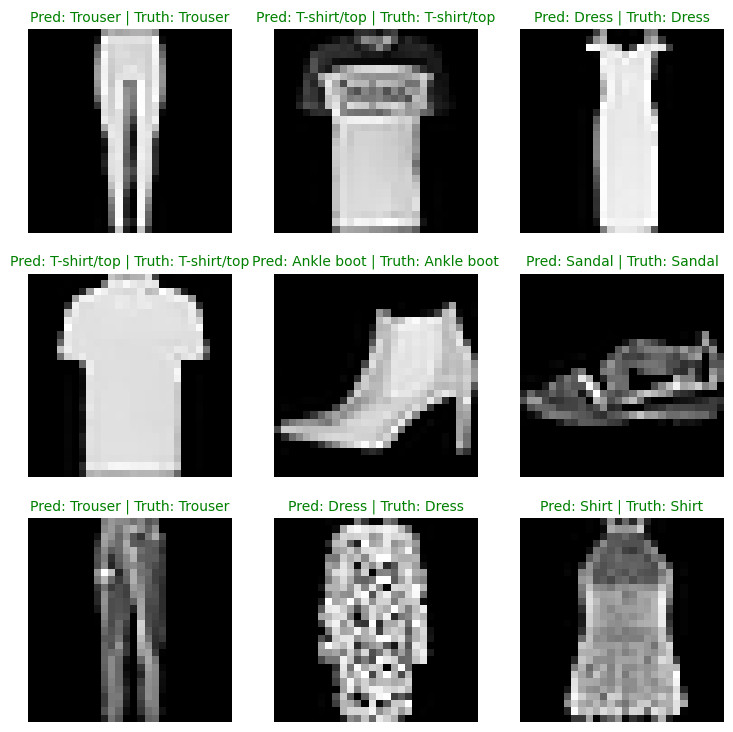

In [19]:
# PLOT PREDICTIONS
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction (in text form, e.g "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)

In [25]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

print("\nModel_2 Results:", model_2_results)

# After 10 epochs, it's still 87%. What gives?  (It's even a little less.)

  0%|          | 0/313 [00:00<?, ?it/s]


Model_2 Results: {'model_name': 'FashionMNISTModelV2', 'model_loss': 0.33566048741340637, 'model_acc': 87.6797124600639}


# Do some real predictions

In [27]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from tqdm.auto import tqdm

In [29]:
# Make predictions with trained model
y_preds = []
model_2.eval()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put prediction ON CPU for evaluation!
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds).to(device)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 4])

# Confusion Matrix

In [32]:
# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")

# Move back to CPU
y_pred_tensor = torch.cat(y_preds).to("cpu")

confmat_tensor = confmat(
    preds=y_pred_tensor, 
    target=test_data.targets  # Labels
)

In [31]:
confmat_tensor

tensor([[709,   3,  17,  53,  10,   0, 202,   0,   6,   0],
        [ 16, 861,   3,  89,   9,   0,  17,   0,   5,   0],
        [ 24,   2, 704,  16, 127,   0, 122,   1,   4,   0],
        [ 22,   8,  13, 874,  21,   0,  55,   0,   6,   1],
        [  8,   4,  92,  48, 739,   0, 102,   0,   6,   1],
        [  5,   1,   5,   4,   8, 791,  17,  66,  75,  28],
        [104,   4,  69,  59,  97,   0, 658,   0,   9,   0],
        [  0,   0,   0,   0,   1,  21,   0, 941,   6,  31],
        [ 17,   5,   9,  18,  18,   5,  16,   5, 905,   2],
        [  0,   0,   0,   0,   1,  21,   5, 130,  31, 812]])

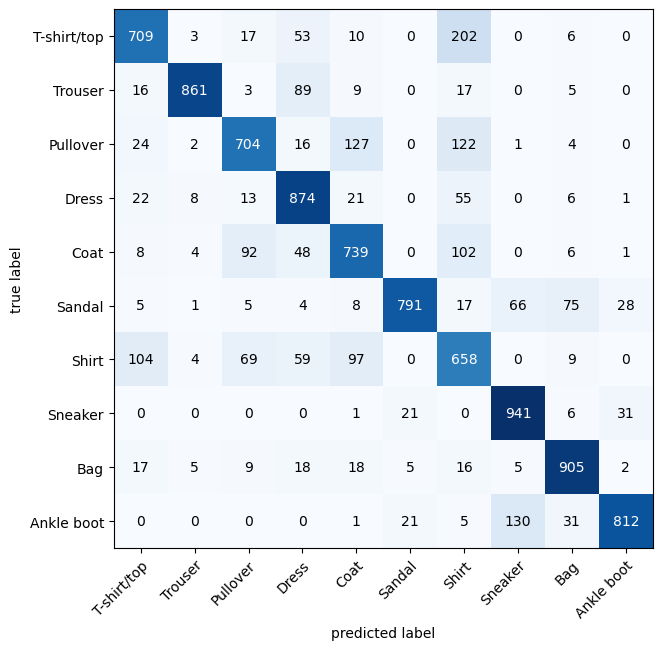

In [33]:
# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib loves numpy
    class_names=class_names,
    figsize=(10, 7)
)

# Note: Labels are sometimes wrong.

## P.S. Don't overwrite below!

Text(0.5, 1.0, 'Trouser')

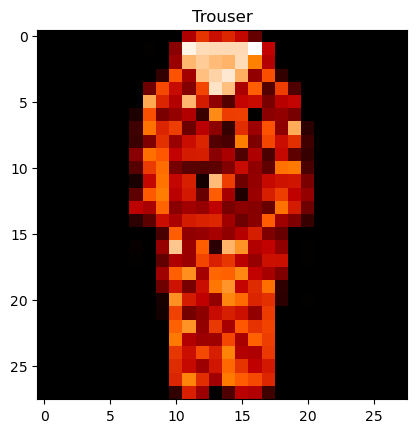

In [31]:
# PLOT THE 8TH ONE
plt.imshow(test_samples[7].squeeze(), cmap="gist_heat")
plt.title(class_names[test_labels[7]])